In [1]:
suppressPackageStartupMessages(suppressWarnings(library(lintr))) # linting
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # used to attach multiple figures into one
suppressPackageStartupMessages(library(png)) # allows to load in figures in memory

In [2]:
# helper functions
load_image <- function(path){
    img <- png::readPNG(path)
    # Convert the image to a raster object
    g <- grid::rasterGrob(img, interpolate=TRUE)

    # Create a ggplot
    p <- ggplot() +
    annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
    theme_void()
    return(p)
}

In [3]:
# getting all paths

# confusing matrix paths
confusion_matrix_path <- file.path("../../results/2.modeling/confusion_matrix.csv.gz")

# f1 score path
f1_score_path <- file.path("../../results/2.modeling/all_f1_scores.csv.gz")

# precision and recall curve path
pr_file_path <- file.path("../../results/2.modeling/precision_recall_scores.csv.gz")

# probability plot
cyto_proba_path <- file.path("../../results/3.jump_analysis/cytoskeletal_proba_scores.csv.gz")

# injury probabilities
injury_proba_path = file.path("../../results/3.jump_analysis/all_injury_proba.csv.gz")

# path to workflow image
wf_image <- file.path("./figures/workflow_fig.png")

# create figures and supplemental dir
dir.create("figures/supplemental", recursive = TRUE)

Warning message in dir.create("figures/supplemental", recursive = TRUE):
“'figures/supplemental' already exists”


In [4]:
# loading all data

# loading confusion matrices
cm_df <- read.csv(confusion_matrix_path, sep = ",")

# loading f1 score paths
f1_df <- read.csv(f1_score_path, sep = ",")

# loading pr curve data
pr_df <- read.csv(pr_file_path)

# loading probabilities
cyto_proba_df <- read.csv(cyto_proba_path)

all_injury_proba_df <- read.csv(injury_proba_path)

# loading workflow image
fig2_A_wf_image <- load_image(wf_image)

In [5]:
# pre-formatting data before plotting

# Update 'shuffled_model' column in cm_df
cm_df <- cm_df %>%
  mutate(shuffled_model = replace(shuffled_model, shuffled_model == "False", "Not Shuffled"),
         shuffled_model = replace(shuffled_model, shuffled_model == "True", "Shuffled"))

# Update 'shuffled' column in f1_df
f1_df <- f1_df %>%
  mutate(shuffled = replace(shuffled, shuffled == "False", "Not Shuffled"),
         shuffled = replace(shuffled, shuffled == "True", "Shuffled"))
# update one of the shuffled_model columns to Shuffled and Not Shuffled
pr_df <- pr_df %>%
  mutate(shuffled = replace(shuffled, shuffled == "False", "Not Shuffled"),
         shuffled = replace(shuffled, shuffled == "True", "Shuffled"))


# Update 'shuffled_model' column in proba_df
cyto_proba_df <- cyto_proba_df %>%
  mutate(shuffled = replace(shuffled, shuffled == "False", "Not Shuffled"),
         shuffled = replace(shuffled, shuffled == "True", "Shuffled"))

# Adding the new column based on the condition
cyto_proba_df <- cyto_proba_df %>%
  mutate(injury = ifelse(grepl('Cytoskeletal', pred_injury), 'Cyto Injury', 'Other Injuries'))

## Update the 'injury' column based on 'datatype' condition
cyto_proba_df <- cyto_proba_df %>%
  mutate(injury = ifelse(datatype == "JUMP Overlap", "Cyto JUMP Overlap", injury))


# Update injury proba columns
all_injury_proba_df <- all_injury_proba_df %>%
  mutate(shuffled = replace(shuffled, shuffled == "False", "Not shuffled"),
         shuffled = replace(shuffled, shuffled == "True", "Shuffled"))

## Figure 2 Panel A: Workflow Diagram

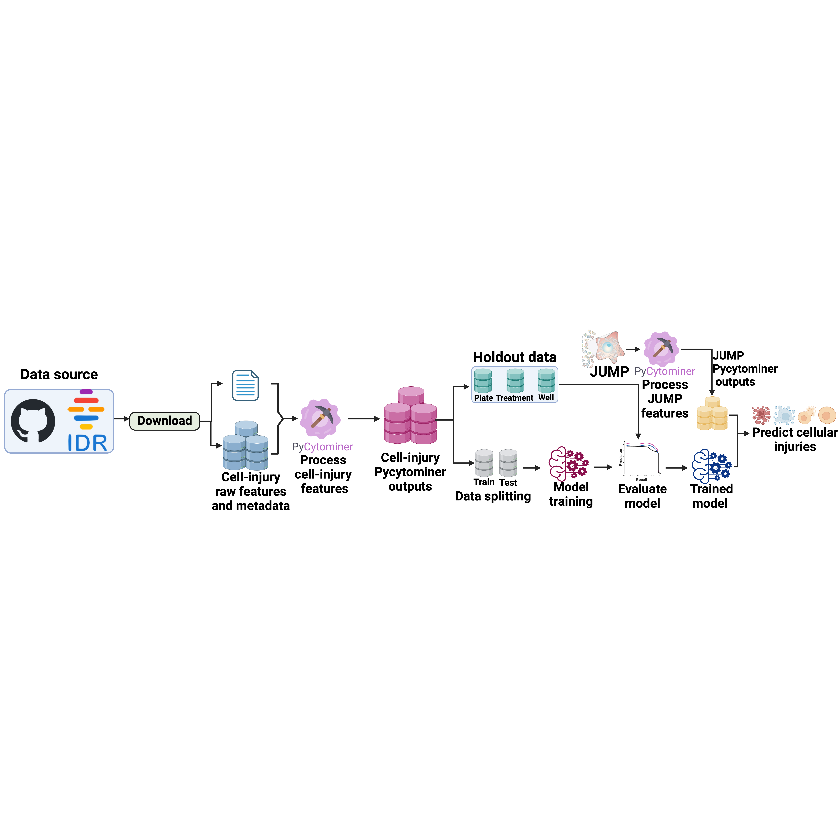

In [6]:
fig2_A_wf_image

## Figure 2 Panel B: PR Cruves for Train and Test split

In [7]:
# Selecting only the Test and Train data splits PR curves
test_train_pr <- pr_df %>%
  filter(dataset_type %in% c("Test", "Train"))

# Selecting only the F1 scores both both testing and training split in the Non-shuffled model
test_train_f1_df <- f1_df %>%
  filter(dataset_type %in% c("Test", "Train"), shuffled == "Not Shuffled")

# Merging both dataframes; However, if the Model is shuffled f1 score will be NaN
pr_f1_curve <- merge(test_train_pr, test_train_f1_df, by = c("dataset_type", "shuffled", "injury_type"), all = TRUE)

# Filtering to only get Test and Train Not shuffled f1 scores
f1_scores_per_injury_df <- pr_f1_curve[, c("dataset_type", "shuffled", "injury_type", "f1_score")] %>%
  filter(dataset_type %in% c("Train", "Test"), shuffled == "Not Shuffled") %>%
  distinct()

# Dropping columns that are no longer needed
f1_scores_per_injury_df <- select(f1_scores_per_injury_df, -shuffled)
f1_scores_per_injury_df$f1_score <- round(f1_scores_per_injury_df$f1_score, 2)

# Filter rows where dataset_type is "Train" and select only the columns we need
train_data <- f1_scores_per_injury_df %>%
  filter(dataset_type == "Train") %>%
  select(injury_type, f1_score) %>%
  rename(train_f1_score = f1_score)

# Merge the filtered dataframe with the original one based on injury_type
f1_scores_per_injury_df <- f1_scores_per_injury_df %>%
  filter(dataset_type == "Test") %>%
  left_join(train_data, by = "injury_type") %>%
  rename(test_f1_score = f1_score) %>%
  select(-dataset_type)

In [8]:
# These values manually move the F1 score box within each subplot.
# The position of these values corresponds to the row of the table below.
x_values <- c(0.50, 0.50, 0.35, 0.30, 0.50, 0.50, 0.40, 0.70, 0.40, 0.40, 0.79, 0.40, 0.79, 0.79, 0.79)
y_values <- c(0.25, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.79, 0.50, 0.79, 0.79, 0.79)

# generate dataframe responsible for placing the f1 boxes within the plot
f1_scores_per_injury_df <- f1_scores_per_injury_df %>%
  mutate(f1_label = paste(
    "F1 score:\nTrain:", sprintf("%.2f", train_f1_score), "\n",
    "Test:", sprintf("%.2f", test_f1_score)
  ),
  x = x_values,
  y = y_values)
f1_scores_per_injury_df

injury_type          test_f1_score train_f1_score
1  Control              0.79          0.80          
2  Cytoskeletal         0.94          0.94          
3  Ferroptosis          0.44          0.40          
4  Genotoxin            0.67          0.73          
5  HDAC                 0.79          0.88          
6  Hsp90                0.82          0.77          
7  Kinase               0.63          0.63          
8  Miscellaneous        0.33          0.33          
9  Mitochondria         0.67          0.62          
10 mTOR                 0.67          0.71          
11 Nonspecific reactive 0.29          0.33          
12 Proteasome           0.68          0.74          
13 Redox                0.46          0.39          
14 Saponin              0.21          0.22          
15 Tannin               0.09          0.10          
   f1_label                             x    y   
1  F1 score:\nTrain: 0.80 \n Test: 0.79 0.50 0.25
2  F1 score:\nTrain: 0.94 \n Test: 0.94 0.50 0.50
3  F1 score:\nTrain: 0.40 \n Test: 0.44 0.35 0.50
4  F1 score:\nTrain: 0.73 \n Test: 0.67 0.30 0.50
5  F1 score:\nTrain: 0.88 \n Test: 0.79 0.50 0.50
6  F1 score:\nTrain: 0.77 \n Test: 0.82 0.50 0.50
7  F1 score:\nTrain: 0.63 \n Test: 0.63 0.40 0.50
8  F1 score:\nTrain: 0.33 \n Test: 0.33 0.70 0.50
9  F1 score:\nTrain: 0.62 \n Test: 0.67 0.40 0.50
10 F1 score:\nTrain: 0.71 \n Test: 0.67 0.40 0.50
11 F1 score:\nTrain: 0.33 \n Test: 0.29 0.79 0.79
12 F1 score:\nTrain: 0.74 \n Test: 0.68 0.40 0.50
13 F1 score:\nTrain: 0.39 \n Test: 0.46 0.79 0.79
14 F1 score:\nTrain: 0.22 \n Test: 0.21 0.79 0.79
15 F1 score:\nTrain: 0.10 \n Test: 0.09 0.79 0.79

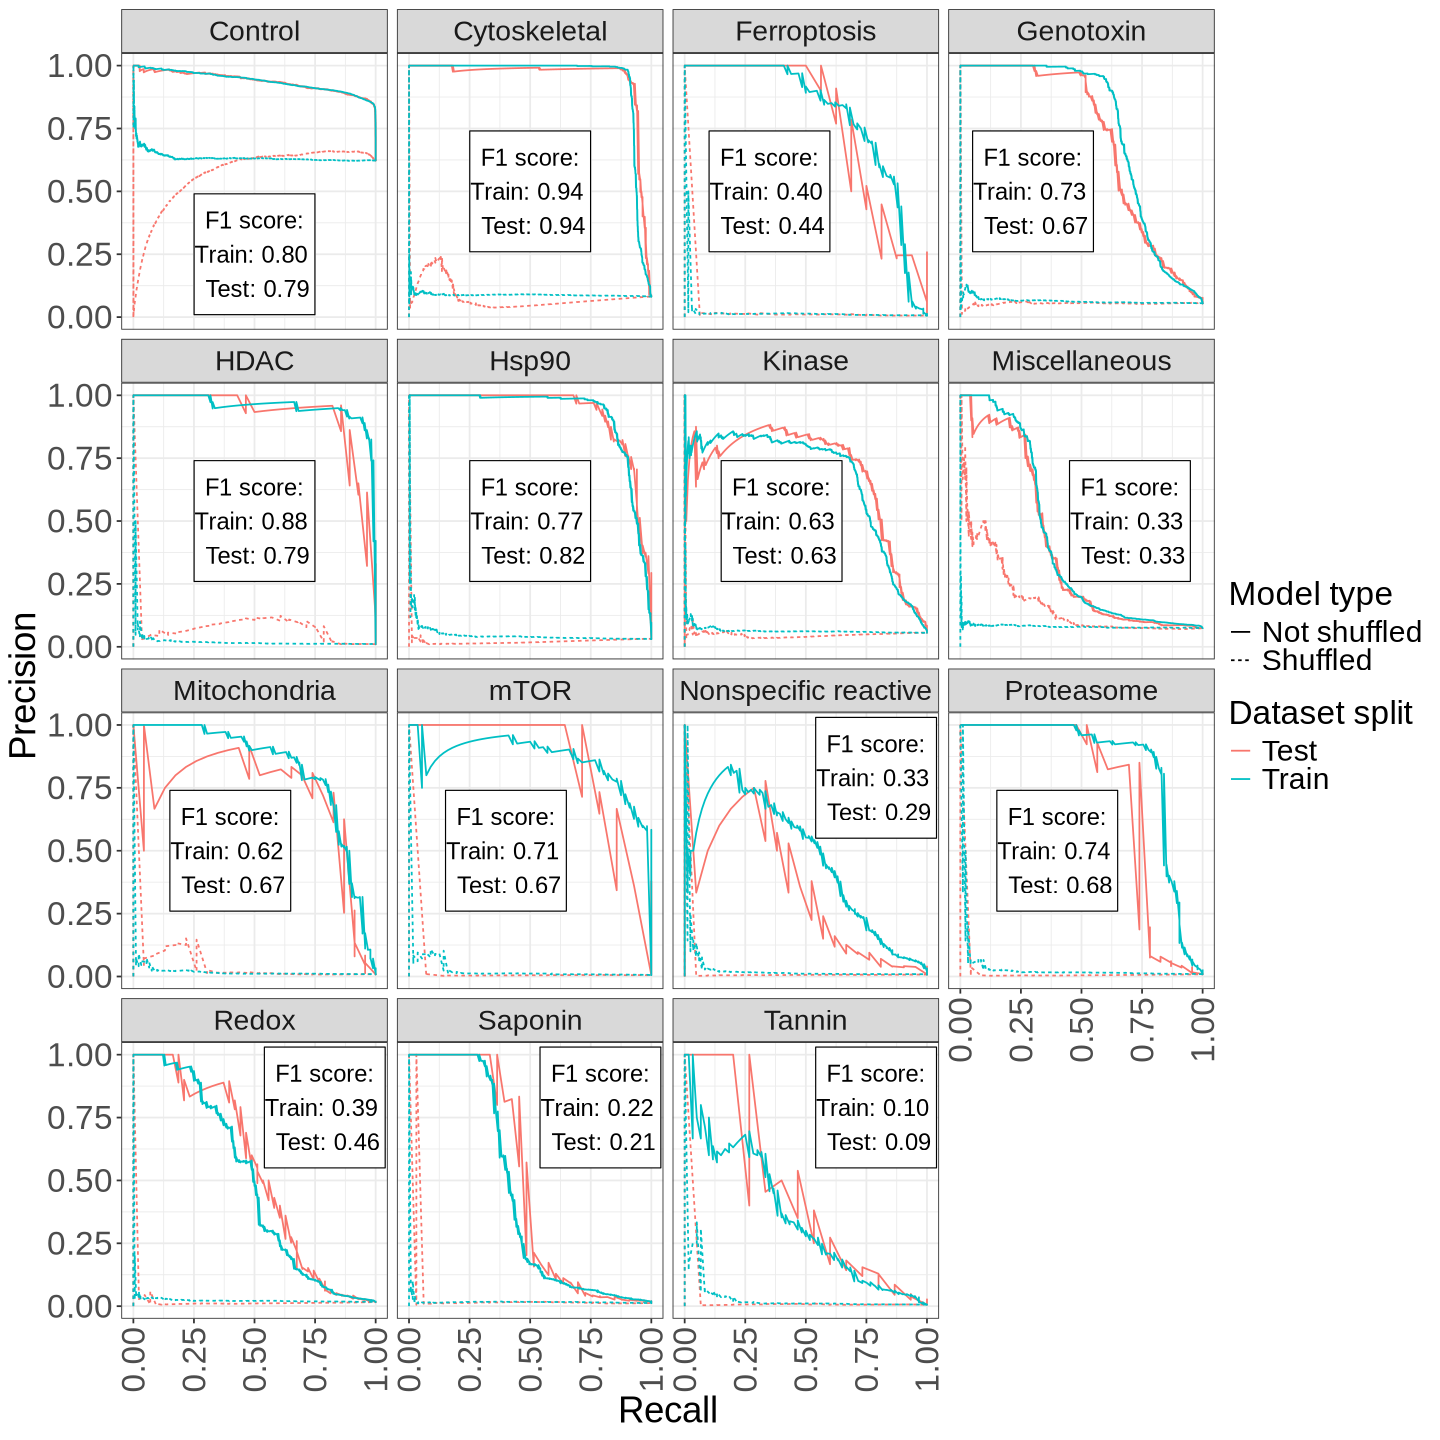

In [9]:
# plot data
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

# Updating label names
pr_f1_curve <- pr_f1_curve %>%
  mutate(shuffled = ifelse(shuffled == "Not Shuffled", "Not shuffled", shuffled))

# # original
fig2_B_pr_curve_plot_train_test <- ggplot(pr_f1_curve, aes(x = recall, y = precision)) +
    geom_line(aes(color = dataset_type, linetype = shuffled)) +
    facet_wrap(~injury_type) +
    xlab("Recall") +
    ylab("Precision") +
    theme_bw() +
    theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.1, "cm"),
        legend.key.size = unit(0.7, "lines"),
        legend.key.width = unit(1, "lines"),
        axis.text.x = element_text(angle = 90, size = 20, vjust = 0.5),
        axis.text.y = element_text(size = 20),
        strip.text = element_text(size = 17),
        strip.text.x = element_text(margin = margin(t=0.2, b=0.2, r=0, l=0, "cm")),
        axis.title = element_text(size = 22),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 18)) +

  # adding labels within the facet
    geom_point(
      data = f1_scores_per_injury_df,
      aes(x = x, y = y),
      shape = 22,      # Use filled circle shape
      size = 38,        # Increase point size
      color = "black", # Point border color
      fill = "white"   # Point fill color (white)
    ) +
    geom_text(
      data = f1_scores_per_injury_df,
      aes(x = x, y = y, label = f1_label),
      hjust = 0.5,  # Center horizontally
      vjust = 0.5,  # Adjust vertically for position
      size = 5,     # Increase font size
      color = "black",  # Text color
      show.legend = FALSE  # Hide legend for this layer
    ) +

    labs(linetype = "Model type", color = "Dataset split")

ggsave("figures/fig2_B_only_test_train_pr_curve.png", width = width, height = height, dpi=900)
fig2_B_pr_curve_plot_train_test

## Figure 2 Panel C: Confusion Matrix with Train and Test split

In [10]:
# creating final model confusion matrix with Non-shuffled data
final_model_cm <- cm_df %>%
  filter(shuffled_model == "Not Shuffled" & dataset_type %in% c("Train", "Test", "Plate Holdout", "Well Holdout")) %>%
  mutate(
    dataset_type = case_when(
      dataset_type == "Plate Holdout" ~ "Plate holdout",
      dataset_type == "Well Holdout" ~ "Well holdout",
      TRUE ~ dataset_type
    )
  )

final_model_cm$dataset_type <- factor(final_model_cm$dataset_type, levels = c("Train", "Test", "Plate holdout", "Well holdout"))

# Define the desired order of x-axis labels
x_label_order <- c('Control', 'Cytoskeletal', 'Hsp90', 'Kinase', 'Genotoxin', 'Miscellaneous', 'Redox', 'HDAC', 'mTOR', 'Proteasome', 'Saponin', 'Mitochondria', 'Ferroptosis', 'Tannin', 'Nonspecific reactive')

# Reorder the predicted_labels factor variable with the desired order
final_model_cm$true_labels <- factor(final_model_cm$true_labels, levels = rev(unique(final_model_cm$true_labels)))
final_model_cm$predicted_labels <- factor(final_model_cm$predicted_labels, levels = x_label_order)



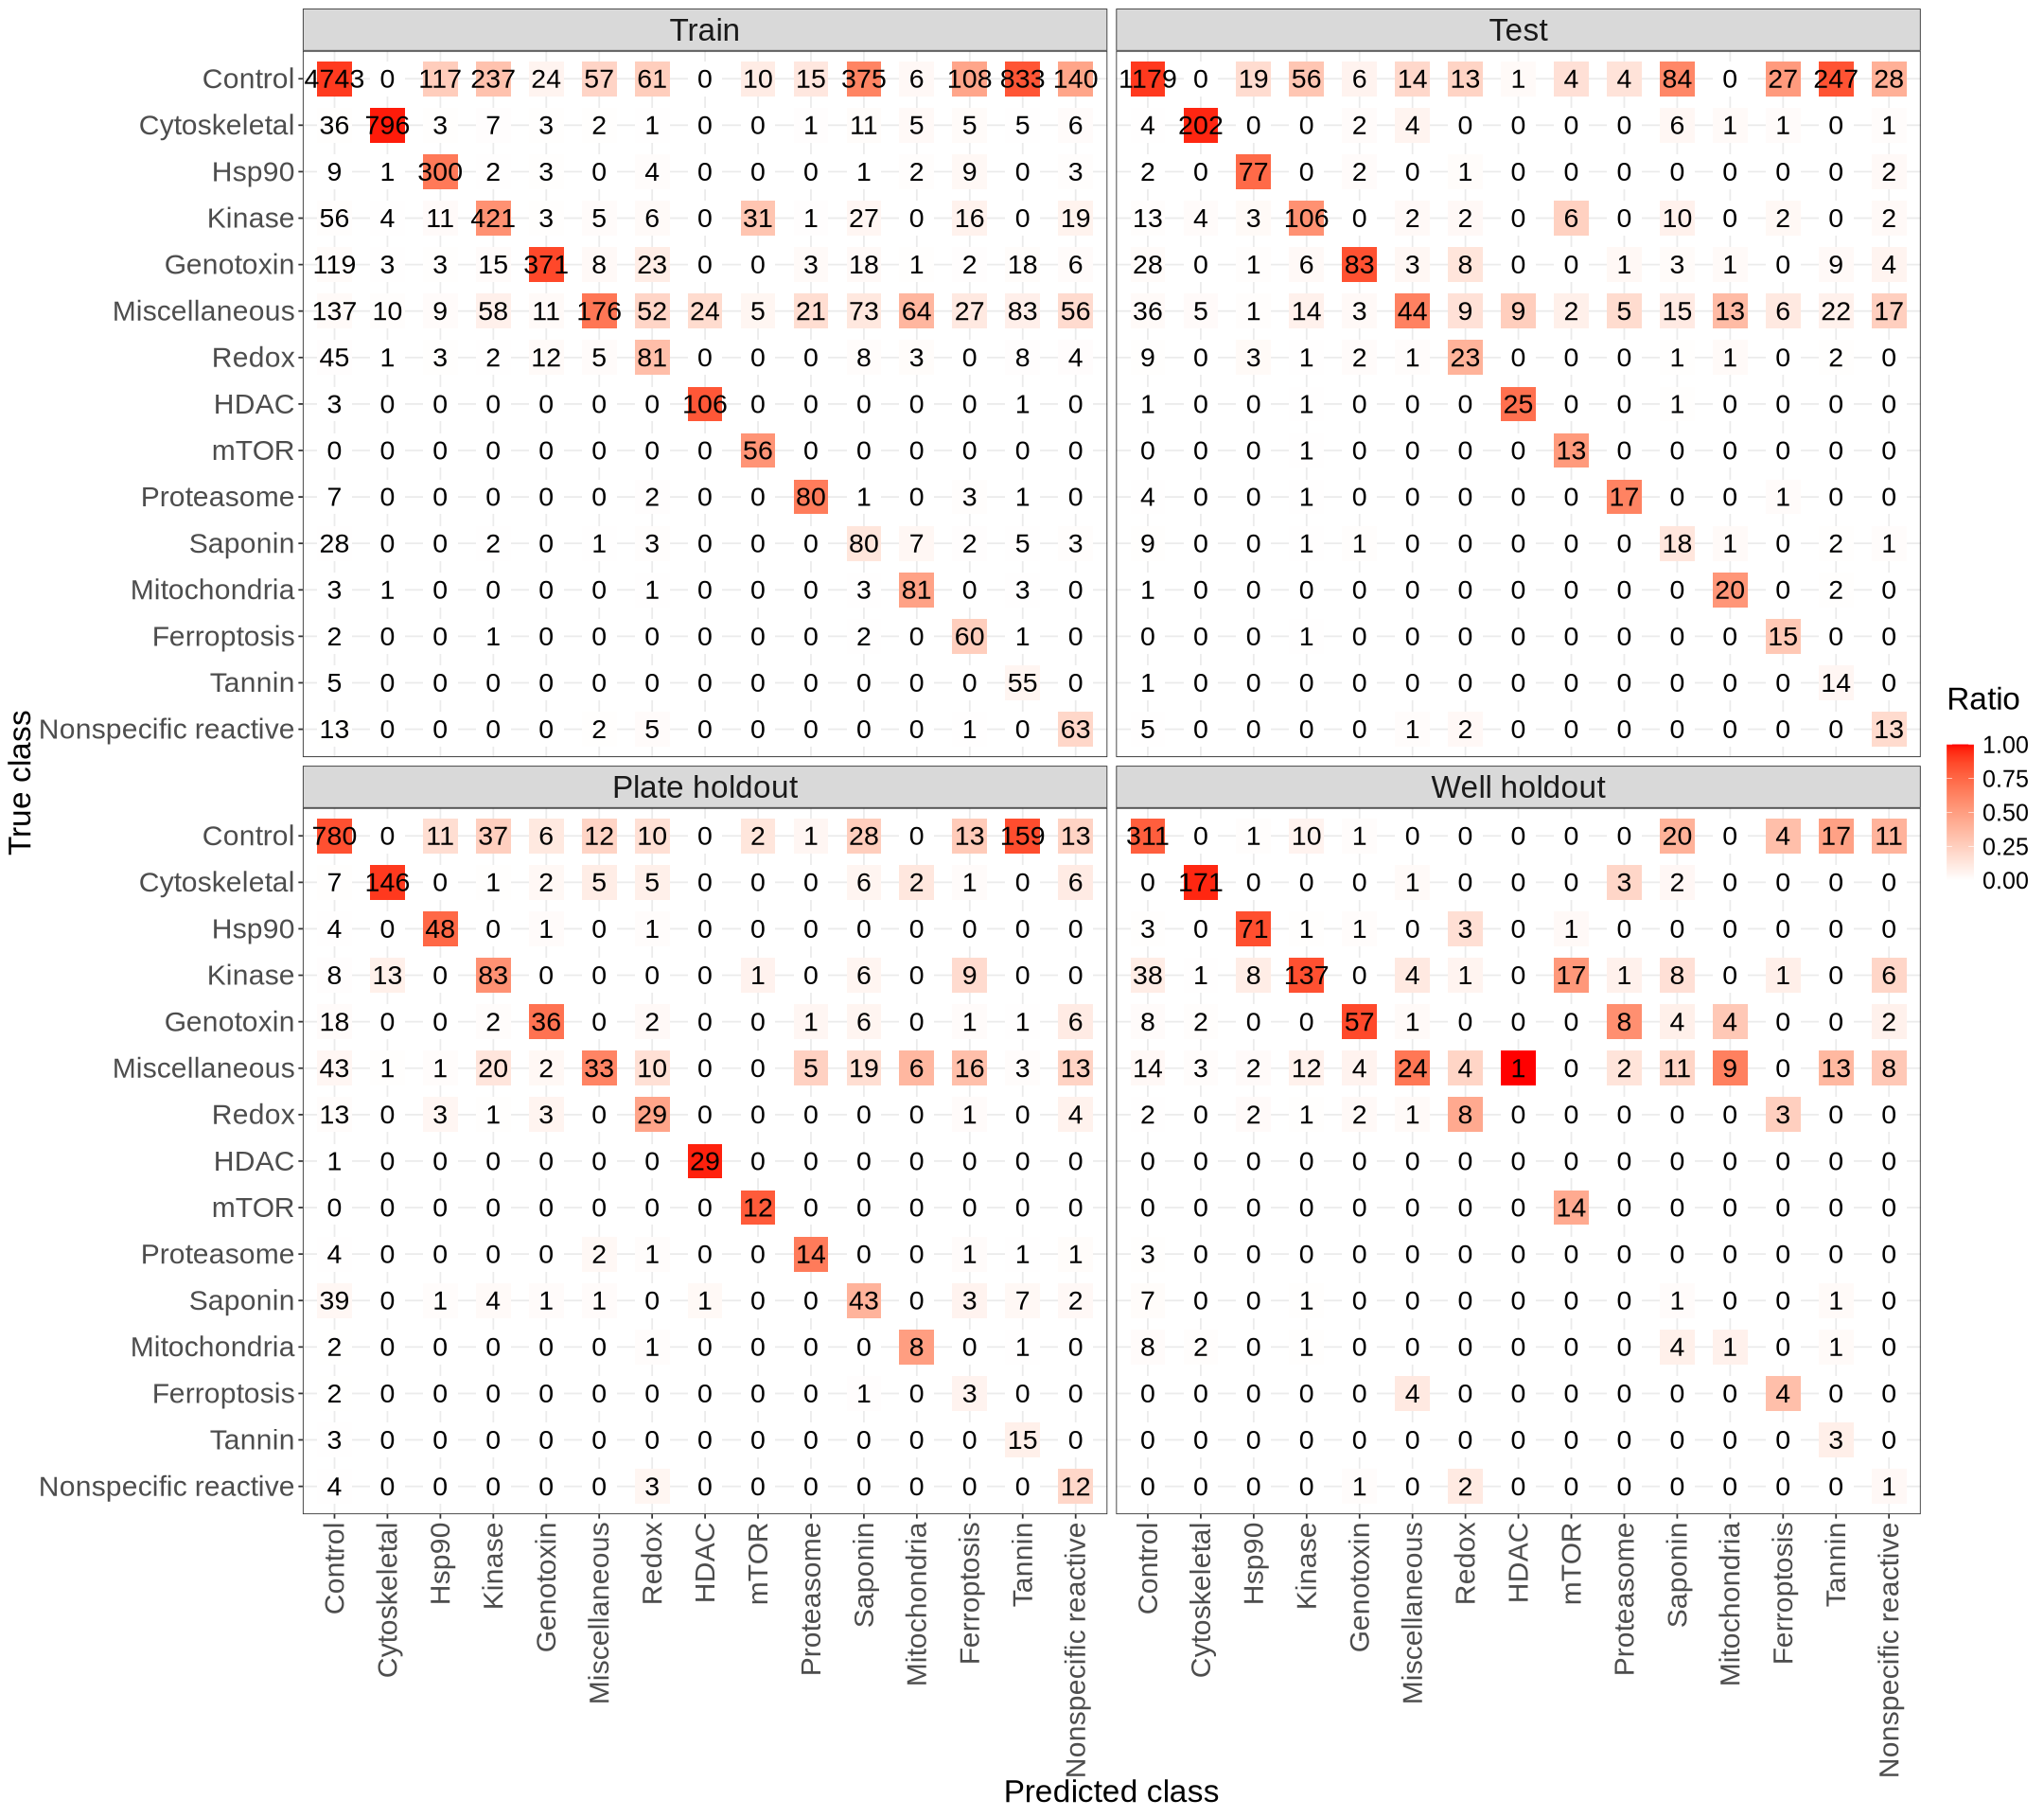

In [11]:
# image size
img_height <- 16
img_width <- 18

options(repr.plot.width = img_width, repr.plot.height = img_height)


# Now proceed with plotting
fig2_C_final_model_cm <- (
    ggplot(final_model_cm, aes(x = predicted_labels, y = true_labels))
    + facet_wrap(~dataset_type)
    + geom_point(aes(color = recall), size = 10, shape = 15)
    + geom_text(aes(label = count), size = 6, )
    + scale_color_gradient("Ratio", low = "white", high = "red", limits = c(0, 1))
    + theme_bw()
    + xlab("Predicted class")
    + ylab("True class")
    + theme(
        # legend settings
        legend.title =  element_text(size = 20, margin = margin(b = 20)),
        legend.text = element_text(size = 15),

        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 18, vjust = 0.5),
        axis.text.y = element_text(hjust = 1, size = 18),
        axis.title.x.bottom = element_text(size = 20),
        axis.title.y.left = element_text(size = 20)
        )
    # + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/fig2_C_training_confusion_matrix.png", height = height, width = width, dpi = 600)

fig2_C_final_model_cm

## Supplemental Figure 2: Confusion matrix with Shuffled model 

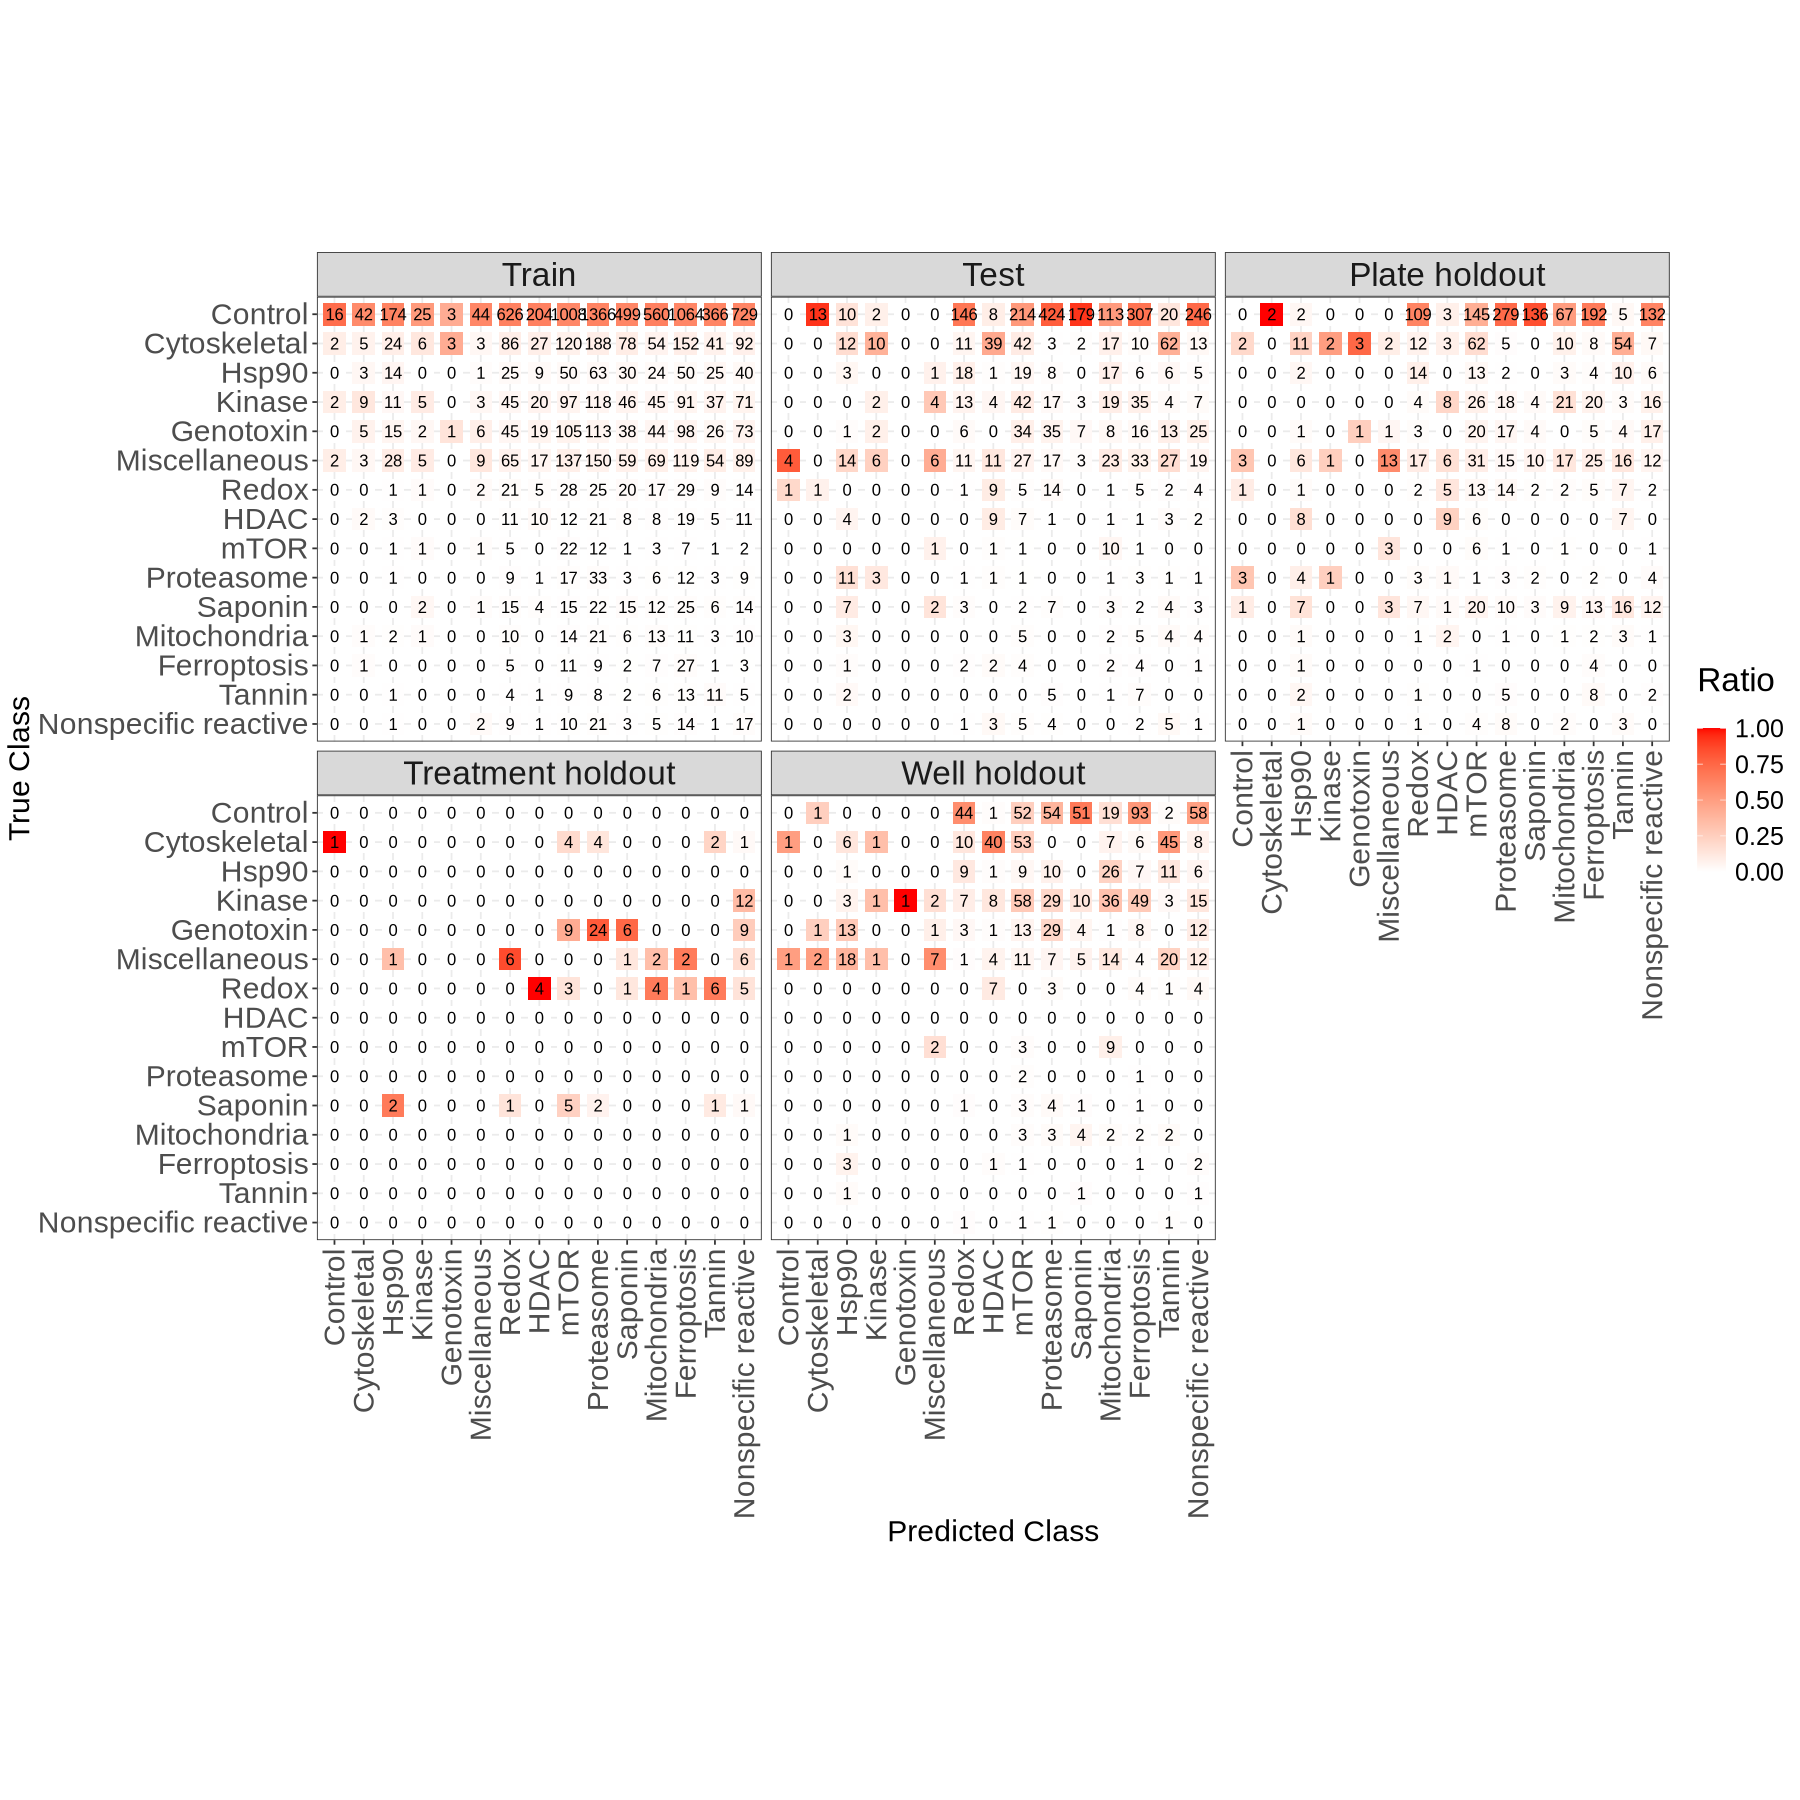

In [12]:
width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)

# creating final model confusion matrix with Non-shuffled data
final_model_cm <- cm_df %>%
  filter(shuffled_model == "Shuffled" & dataset_type %in% c("Train", "Test", "Plate Holdout", "Treatment Holdout", "Well Holdout")) %>%
  mutate(dataset_type = case_when(
    dataset_type == "Train" ~ "Train",
    dataset_type == "Test" ~ "Test",
    dataset_type == "Plate Holdout" ~ "Plate holdout",
    dataset_type == "Treatment Holdout" ~ "Treatment holdout",
    dataset_type == "Well Holdout" ~ "Well holdout"
  ))

# Reorder the predicted_labels factor variable with the desired order
x_label_order <- c('Control', 'Cytoskeletal', 'Hsp90', 'Kinase', 'Genotoxin', 'Miscellaneous', 'Redox', 'HDAC', 'mTOR', 'Proteasome', 'Saponin', 'Mitochondria', 'Ferroptosis', 'Tannin', 'Nonspecific reactive')
final_model_cm$true_labels <- factor(final_model_cm$true_labels, levels = rev(unique(final_model_cm$true_labels)))
final_model_cm$predicted_labels <- factor(final_model_cm$predicted_labels, levels = x_label_order)

# Define the desired order of facet levels
facet_order <- c("Train", "Test", "Plate holdout", "Treatment holdout", "Well holdout")
final_model_cm$dataset_type <- factor(final_model_cm$dataset_type, levels = facet_order)

sfig2_model_cm <- (
    ggplot(final_model_cm, aes(y = true_labels, x = predicted_labels))
    + facet_wrap(~dataset_type)
    + geom_point(aes(color = recall), size = 6, shape = 15)
    + geom_text(aes(label = count), size = 3.5)
    + scale_color_gradient("Ratio", low = "white", high = "red", limits = c(0, 1))
    + theme_bw()
    + xlab("Predicted Class")
    + ylab("True Class")
      + theme(
        # legend settings
        legend.title =  element_text(size = 20, margin = margin(b = 20)),
        legend.text = element_text(size = 15),
        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 18, vjust = 0.5),
        axis.text.y = element_text(hjust = 1, size = 18),
        axis.title.x.bottom = element_text(size = 18),
        axis.title.y.left = element_text(size = 18)
        )
    + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/supplemental/sfig2_shuffled_confusion_matrix.png", height = height, width = width, dpi = 600)

sfig2_model_cm

## Supplemental Figure 3: Confusion matrix of Under Performing Treatment Holdout Predictions 

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”


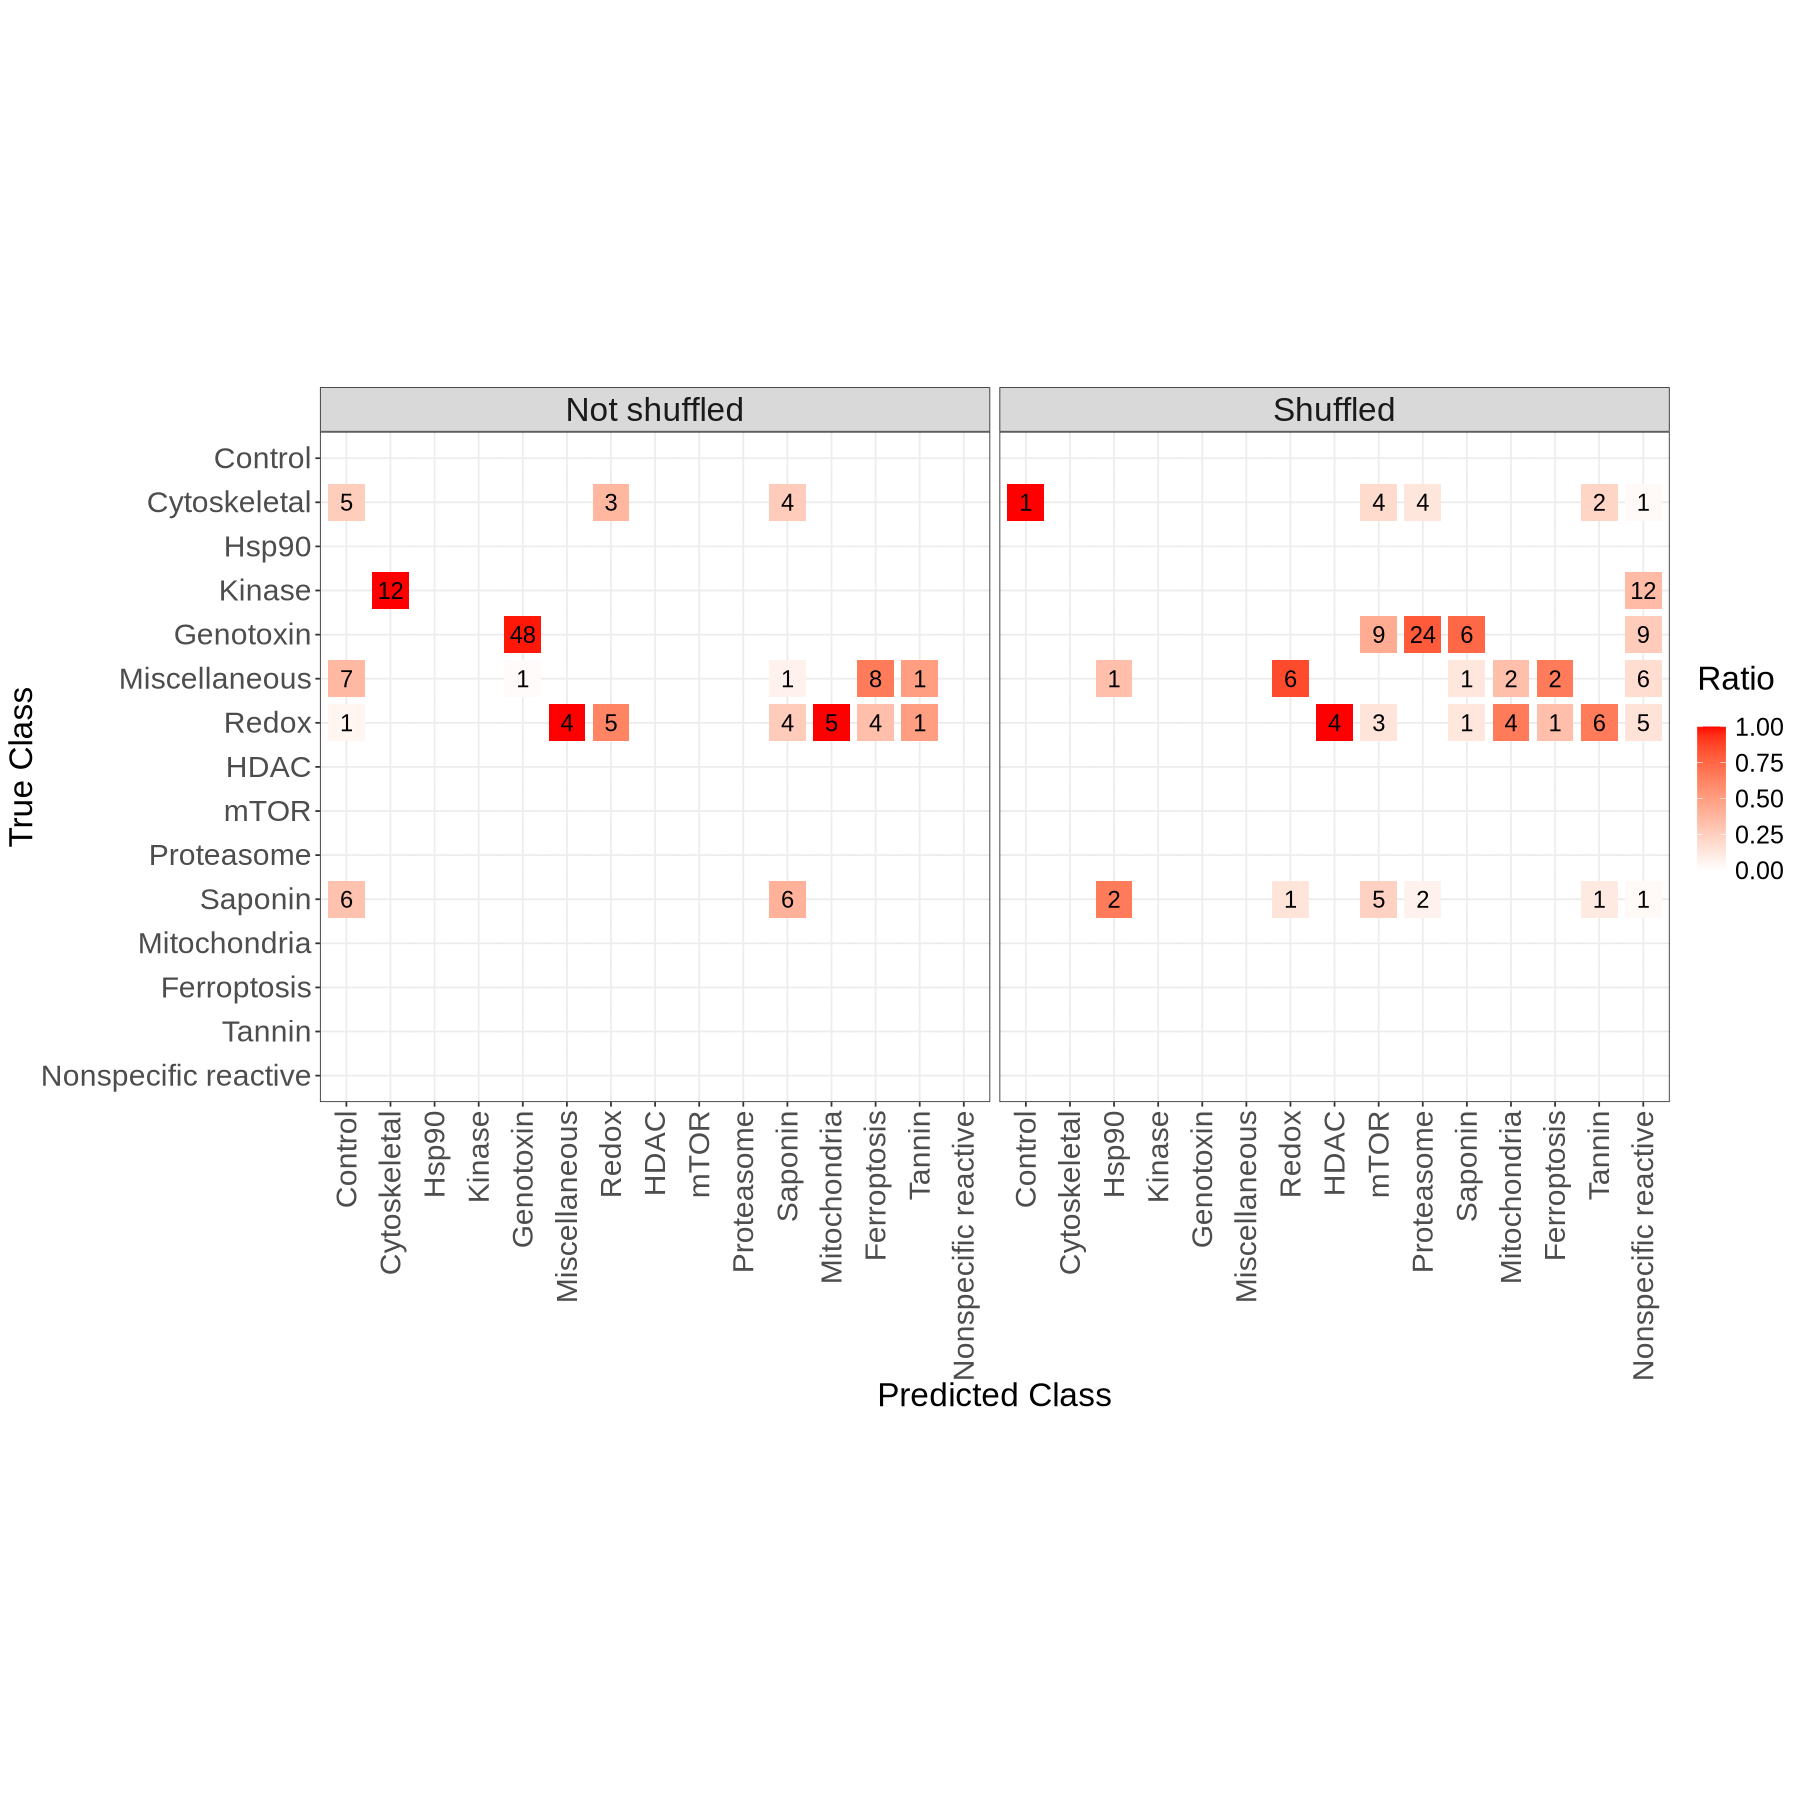

In [13]:
# creating final model confusion matrix with Non-shuffled data
treat_cm <- cm_df %>%
  filter(shuffled_model %in% c("Not Shuffled", "Shuffled") & dataset_type %in% "Treatment Holdout")

# remove Title casing from "Not Shuffled" and edit it to "Not shuffled"
treat_cm$shuffled_model <- ifelse(treat_cm$shuffled_model == "Not Shuffled", "Not shuffled", treat_cm$shuffled_model)

# Define the desired order of x-axis labels
x_label_order <- c('Control', 'Cytoskeletal', 'Hsp90', 'Kinase', 'Genotoxin', 'Miscellaneous', 'Redox', 'HDAC', 'mTOR', 'Proteasome', 'Saponin', 'Mitochondria', 'Ferroptosis', 'Tannin', 'Nonspecific reactive')

# Reorder the predicted_labels factor variable with the desired order
treat_cm$true_labels <- factor(treat_cm$true_labels, levels = rev(unique(treat_cm$true_labels)))
treat_cm$predicted_labels <- factor(treat_cm$predicted_labels, levels = x_label_order)

# Add a column to indicate if recall is 0 or not
treat_cm$recall_zero <- ifelse(treat_cm$recall == 0, TRUE, FALSE)

# size of plot
width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)

sfig3_treatment_holdout_cm <- (
    ggplot(treat_cm, aes(x = predicted_labels, y = true_labels))
    + facet_wrap(~shuffled_model)
    + scale_color_gradient("Ratio", low = "white", high = "red", limits = c(0, 1))
    + geom_point(aes(color = recall, alpha = !recall_zero), size = 10, shape = 15)
    + geom_text(aes(label = ifelse(count > 0, as.character(count), "")), size = 5)
    + theme_bw()
    + xlab("Predicted Class")
    + ylab("True Class")
    + guides(alpha = FALSE)  # Remove the legend for alpha
    + theme(
        # legend settings
        legend.title =  element_text(size = 20, margin = margin(b = 20)),
        legend.text = element_text(size = 15),
        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 18),
        axis.text.y = element_text(hjust = 1, size = 18),
        axis.title.x.bottom = element_text(size = 20),
        axis.title.y.left = element_text(size = 20)
        )
    + ggplot2::coord_fixed())

# saving file
ggsave(filename = "figures/supplemental/sfig3_treatment_holdout_confusion_matrix.png", height = height, width = width, dpi = 600)

sfig3_treatment_holdout_cm


## Figure 2 Panel D: Probabilities

Picking joint bandwidth of 0.0221

Picking joint bandwidth of 0.0221



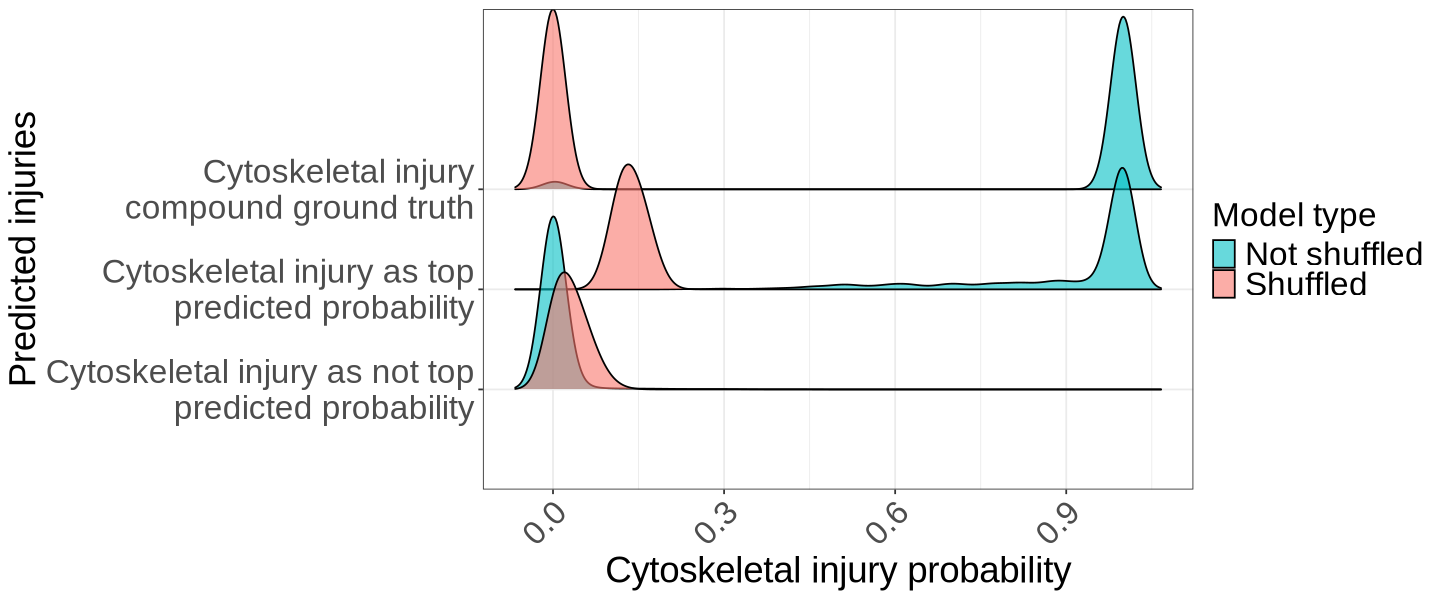

In [14]:
# Define the desired order of y-axis labels
desired_order <- c("Other Injuries", "Cyto Injury", "Cyto JUMP Overlap")

# Define corresponding descriptions for the labels
label_descriptions <- c(
  "Other Injuries" = "Cytoskeletal injury as not top\n predicted probability",
  "Cyto Injury" = "Cytoskeletal injury as top\n predicted probability",
  "Cyto JUMP Overlap" = "Cytoskeletal injury\n compound ground truth"
)

# Convert the 'injury' variable to factor with the desired order of levels
cyto_proba_df$injury <- factor(cyto_proba_df$injury, levels = desired_order)

# Updating label names
cyto_proba_df <- cyto_proba_df %>%
  mutate(shuffled = ifelse(shuffled == "Not Shuffled", "Not shuffled", shuffled))

img_height <- 5
img_width <- 12

options(repr.plot.width = img_width, repr.plot.height = img_height)

fig2_D_probabilities_ridge_plot <- (
  ggplot(cyto_proba_df, aes(x = Cytoskeletal, y = injury, fill = shuffled)) +
    geom_density_ridges(alpha = 0.6) +
    theme_bw() +
    theme(
      axis.text.x = element_text(size = 20, angle = 45, hjust = 1),
      axis.text.y = element_text(size = 20),
      axis.title = element_text(size = 22),
      legend.title = element_text(size = 20),
      legend.text = element_text(size = 20),
      legend.spacing.y = unit(0.1, "cm"),
      legend.box.spacing = unit(0.2, "cm"),
      legend.key.size = unit(0.7, "lines"),
      legend.key.width = unit(1, "lines")
    ) +
    scale_fill_manual(values = c(
      "Shuffled" = "#f8766d",
      "Not shuffled" = "#03bfc4"
    )) +
    labs(
      y = "Predicted injuries",
      x = "Cytoskeletal injury probability",
      fill = "Model type"
    ) +
    scale_y_discrete(labels = label_descriptions, expand = expansion(add = c(1, 0)))

)
ggsave(filename = "figures/fig2_D_JUMP_cyto_injury_probability_ridgeplot.png", height = height, width = width, dpi = 600)

fig2_D_probabilities_ridge_plot


## Supplmental Figure 4: Ridge plot of other Injuries

In [15]:
# Subset the dataframe to drop rows where datatype equals "JUMP Overlap"
jump_proba_no_cyto <- subset(all_injury_proba_df, datatype != "JUMP Overlap")
head(jump_proba_no_cyto)

pred_injury  datatype shuffled     injury_compared_to proba       
1 Ferroptosis  JUMP     Not shuffled Control            1.438464e-17
2 Mitochondria JUMP     Not shuffled Control            1.715604e-12
3 Mitochondria JUMP     Not shuffled Control            1.297985e-09
4 Mitochondria JUMP     Not shuffled Control            8.163913e-14
5 Mitochondria JUMP     Not shuffled Control            8.853317e-08
6 Mitochondria JUMP     Not shuffled Control            1.646288e-10

In [16]:
# Load the required libraries
library(patchwork)

# Define image dimensions
img_height <- 5
img_width <- 12

# setting class order
class_order <-  c('Control', 'Cytoskeletal', 'Hsp90', 'Kinase', 'Genotoxin', 'Miscellaneous', 'Redox', 'HDAC', 'mTOR', 'Proteasome', 'Saponin', 'Mitochondria', 'Ferroptosis', 'Tannin', 'Nonspecific reactive')

# storing legend object
legend_plot <- list()
# storing plots
ridge_plots_list <- list()


# Loop through each class
for (i in 1:length(class_order)) {
  class <- class_order[i]

  # Skip if the class is "Cytoskeletal" since it's in the panel
  if (class == "Cytoskeletal") {
    next  # Skip to the next iteration of the loop
  }

  # Sub-dataframe for equal pred_injury and injury_compared_to
  # Add a column indicating the rows are matched and rename it to "label"
  equal_df <- jump_proba_no_cyto[jump_proba_no_cyto$pred_injury == class & jump_proba_no_cyto$injury_compared_to == class, ]
  equal_df <- equal_df %>%
    mutate(label = "Wells predicted\nas selected injury")

  # Sub-dataframe for not equal pred_injury and injury_compared_to
  # Add a column indicating the rows are not matched and rename it to "label"
  not_equal_df <- jump_proba_no_cyto[jump_proba_no_cyto$injury_compared_to == class & jump_proba_no_cyto$pred_injury != class, ]
  not_equal_df <- not_equal_df %>%
    mutate(label = "Wells not predicted\nas selected injury")

  # Concatenate the two dataframes after rearranging the rows
  concatenated_class_df <- rbind(equal_df, not_equal_df)

  # Count index per class
  index_count <- sum(jump_proba_no_cyto$pred_injury == class & jump_proba_no_cyto$injury_compared_to == class) +
                 sum(jump_proba_no_cyto$injury_compared_to == class & jump_proba_no_cyto$pred_injury != class)

  # Create ridge plot for the concatenated dataframe
  ridge_plot <- ggplot(concatenated_class_df, aes(x = proba, y = label, fill = shuffled)) +
    geom_density_ridges(alpha = 0.6) +
    theme_bw() +
    labs(title= paste(class, "injury probability"),  fill = "Model type: ") +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_text(size = 20),
      # axis.text.x = element_text(size = 20, angle = 45, hjust = 1),
      axis.text.y = element_text(size = 20),
      axis.title = element_text(size = 22),
      axis.title.y = element_blank(),
      plot.title = element_text(size = 23, hjust = 0.5, face = "bold"),
      legend.title = element_text(size = 20),
      legend.text = element_text(size = 20),
      legend.spacing.y = unit(0.1, "cm"),
      legend.box.spacing = unit(0.2, "cm"),
      legend.key.size = unit(0.7, "lines"),
      legend.key.width = unit(1, "lines"),
      legend.position = "none"
    ) +
    scale_fill_manual(values = c(
      "Shuffled" = "#f8766d",
      "Not shuffled" = "#03bfc4"
    )) +
    scale_x_continuous(breaks = seq(0, 1, by = 0.25))

  # add margin top of title except for the last two
  if (i != 14 && i != 15) {
    ridge_plot <- ridge_plot + theme(
      plot.title = element_text(hjust = 0.5, margin = margin(t = 20))
    )
  }

  # remove x label ticks of if not these indexes
  if (!(i %in% c(13, 14, 15))) {
    ridge_plot <- ridge_plot + theme(axis.text.x = element_blank())
  }

  # remove y label ticks if not these indexes
  if (!(i %in% c(1, 5, 8, 11, 14))) {
    ridge_plot <- ridge_plot + theme(axis.text.y = element_blank())
  }

  # add legend on the last subplot
  if (i == 15) {
    ridge_plot <- ridge_plot + theme(legend.position = "bottom",
                                     legend.title = element_text(size = 30),
                                     legend.text = element_text(size = 25),
                                     legend.margin = margin(t = 25)
                                     )
  }

  # storing plots
  ridge_plots_list[[class]] <- ridge_plot
}

Picking joint bandwidth of 0.015

Picking joint bandwidth of 0.0244

Picking joint bandwidth of 0.012

Picking joint bandwidth of 0.0114

Picking joint bandwidth of 0.0214

Picking joint bandwidth of 0.031

Picking joint bandwidth of 0.0243

Picking joint bandwidth of 0.0226

Picking joint bandwidth of 0.0291

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0204

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0217

Picking joint bandwidth of 0.0213

Picking joint bandwidth of 0.015

Picking joint bandwidth of 0.0244

Picking joint bandwidth of 0.012

Picking joint bandwidth of 0.0114

Picking joint bandwidth of 0.0214

Picking joint bandwidth of 0.031

Picking joint bandwidth of 0.0243

Picking joint bandwidth of 0.0226

Picking joint bandwidth of 0.0291

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0204

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0217

Picking joint bandwidth of 0.0213



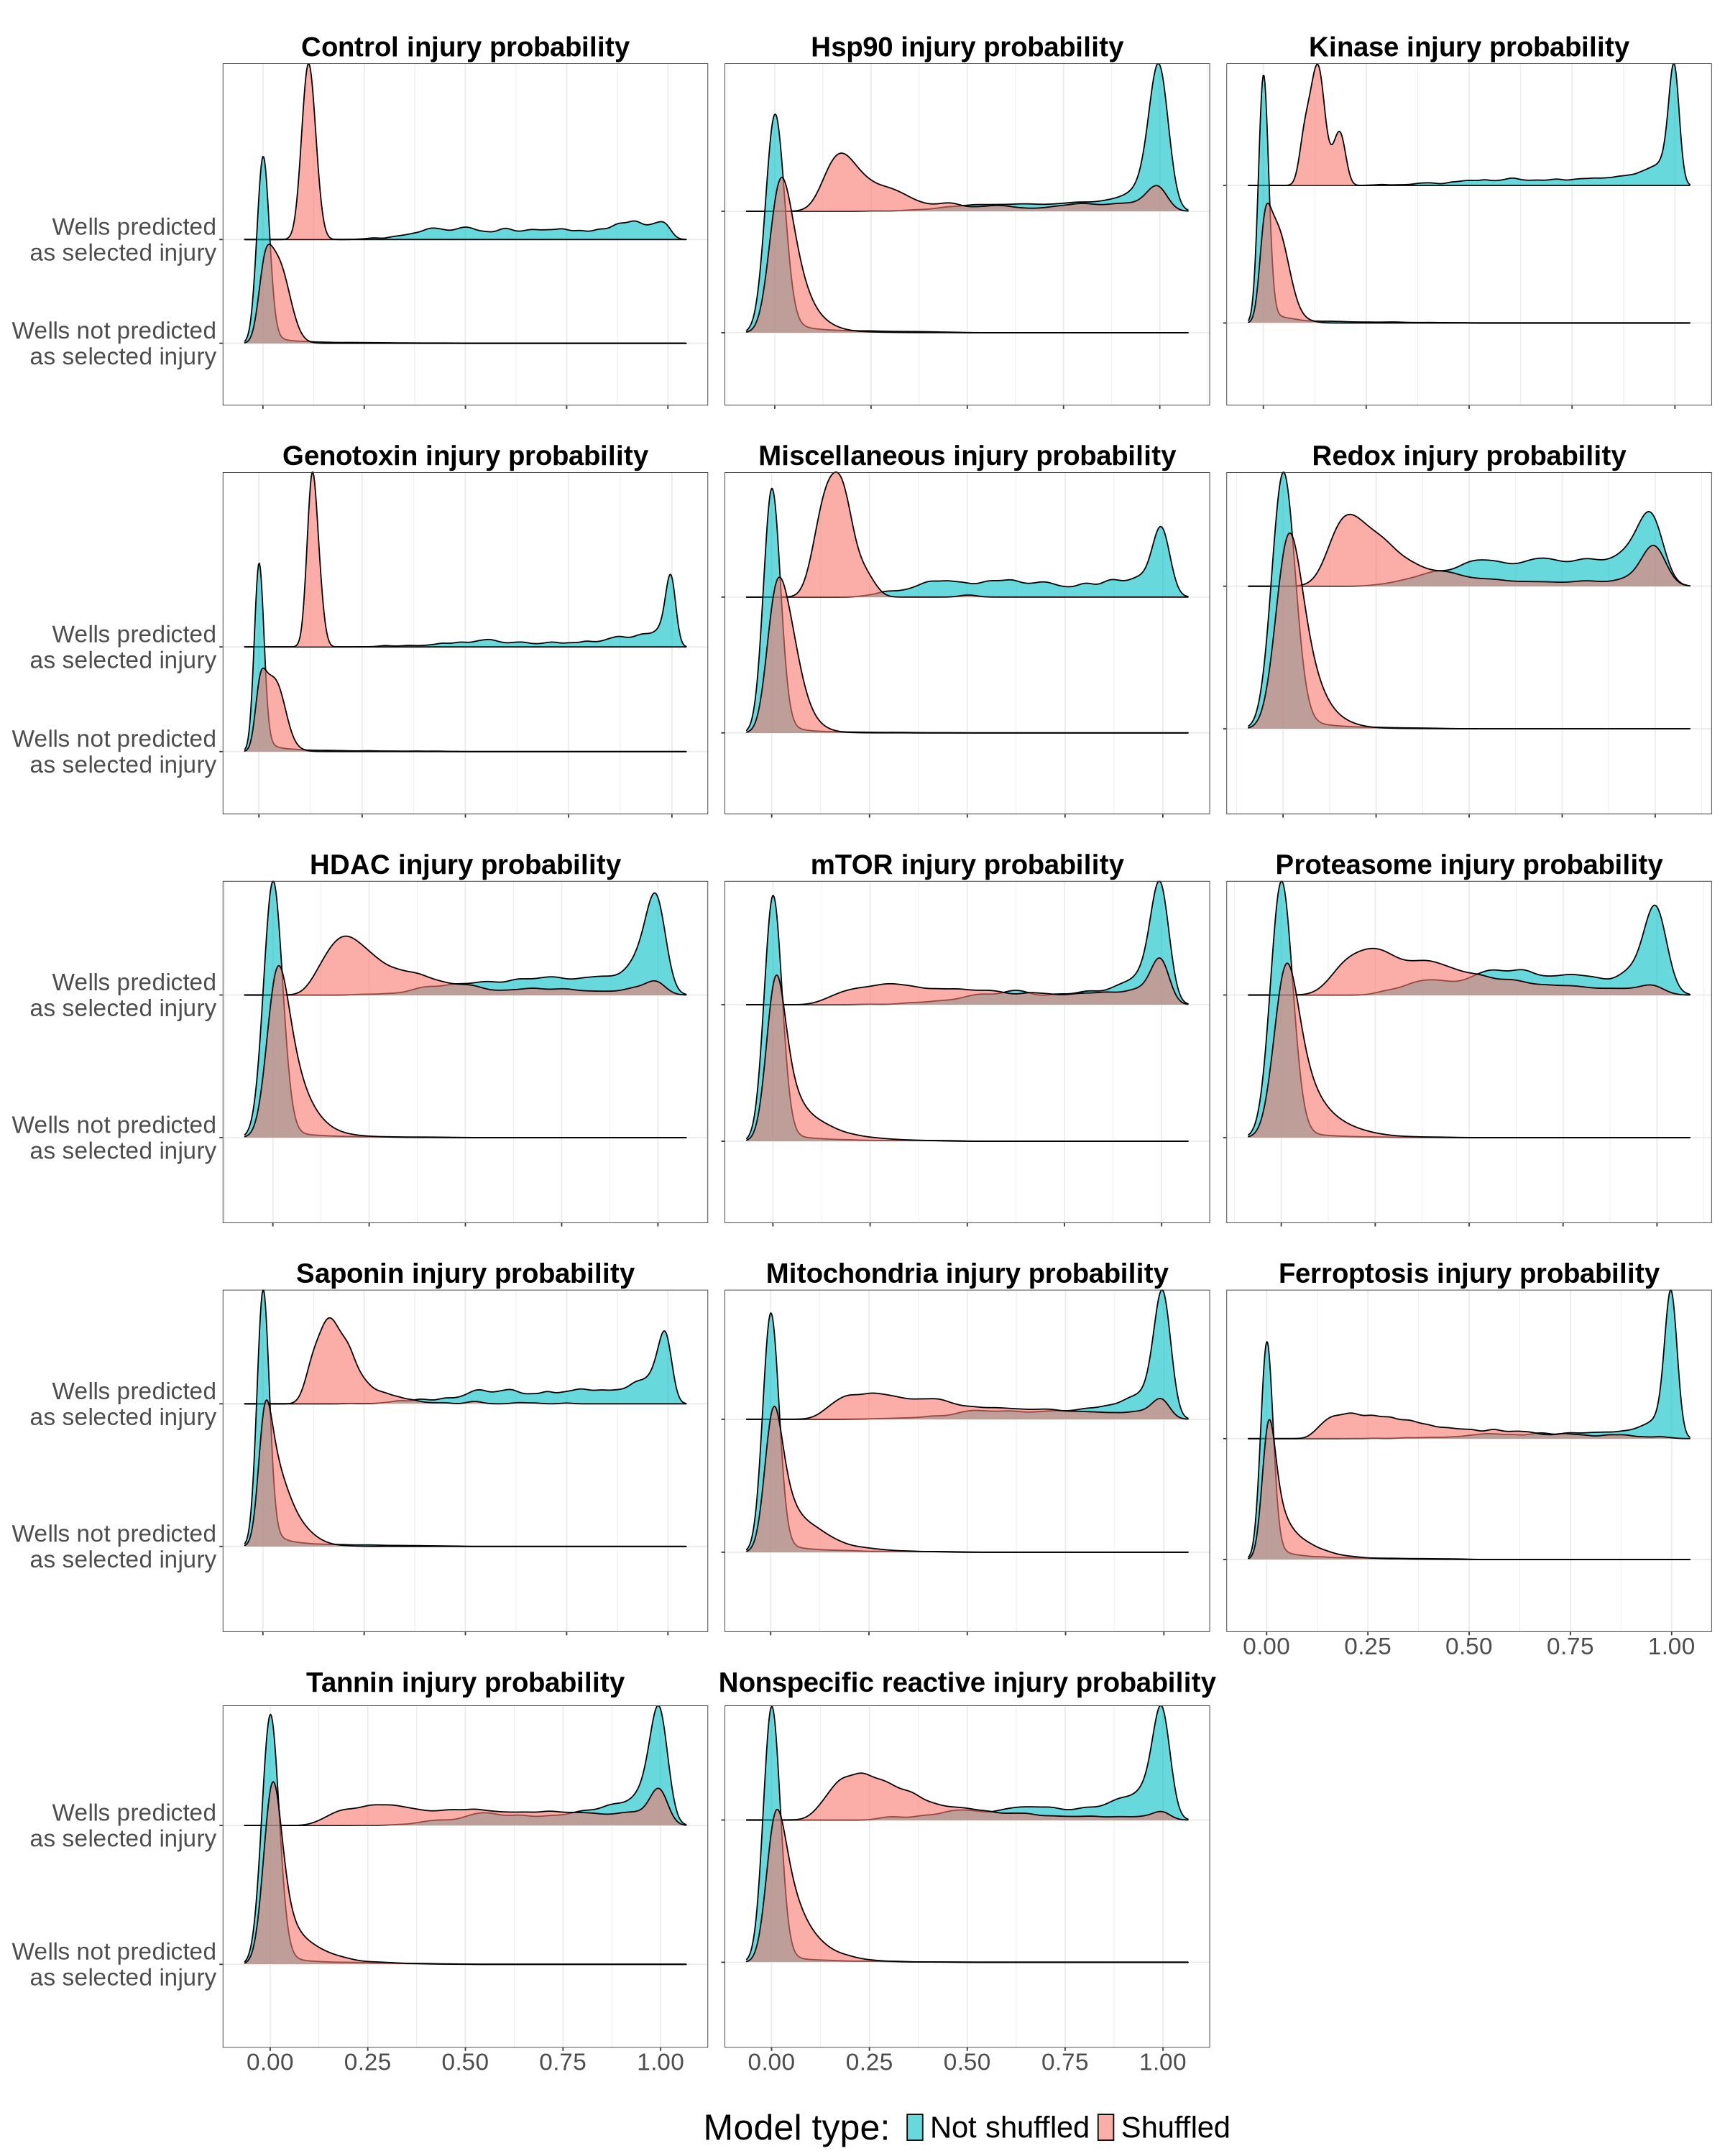

In [17]:
img_height <- 25
img_width <- 20

options(repr.plot.width = img_width, repr.plot.height = img_height)

# # Create an empty plot for the last empty space
# empty_plot <- ggplot() + theme_void()

# Convert the list of ridge plots to a patchwork layout
all_injury_probas_ridge_plot <- wrap_plots(ridge_plots_list[1:14], ncol = 3)

# Print the combined ridge plots
all_injury_probas_ridge_plot

# Save the plot
ggsave(
  plot = all_injury_probas_ridge_plot,
  filename = "figures/supplemental/sfig4_all_injury_probabilities.png",
  height = img_height,
  width = img_width,
  dpi = 700
)

## Finalizing figure 2 with patchwork

Picking joint bandwidth of 0.0221

Picking joint bandwidth of 0.0221



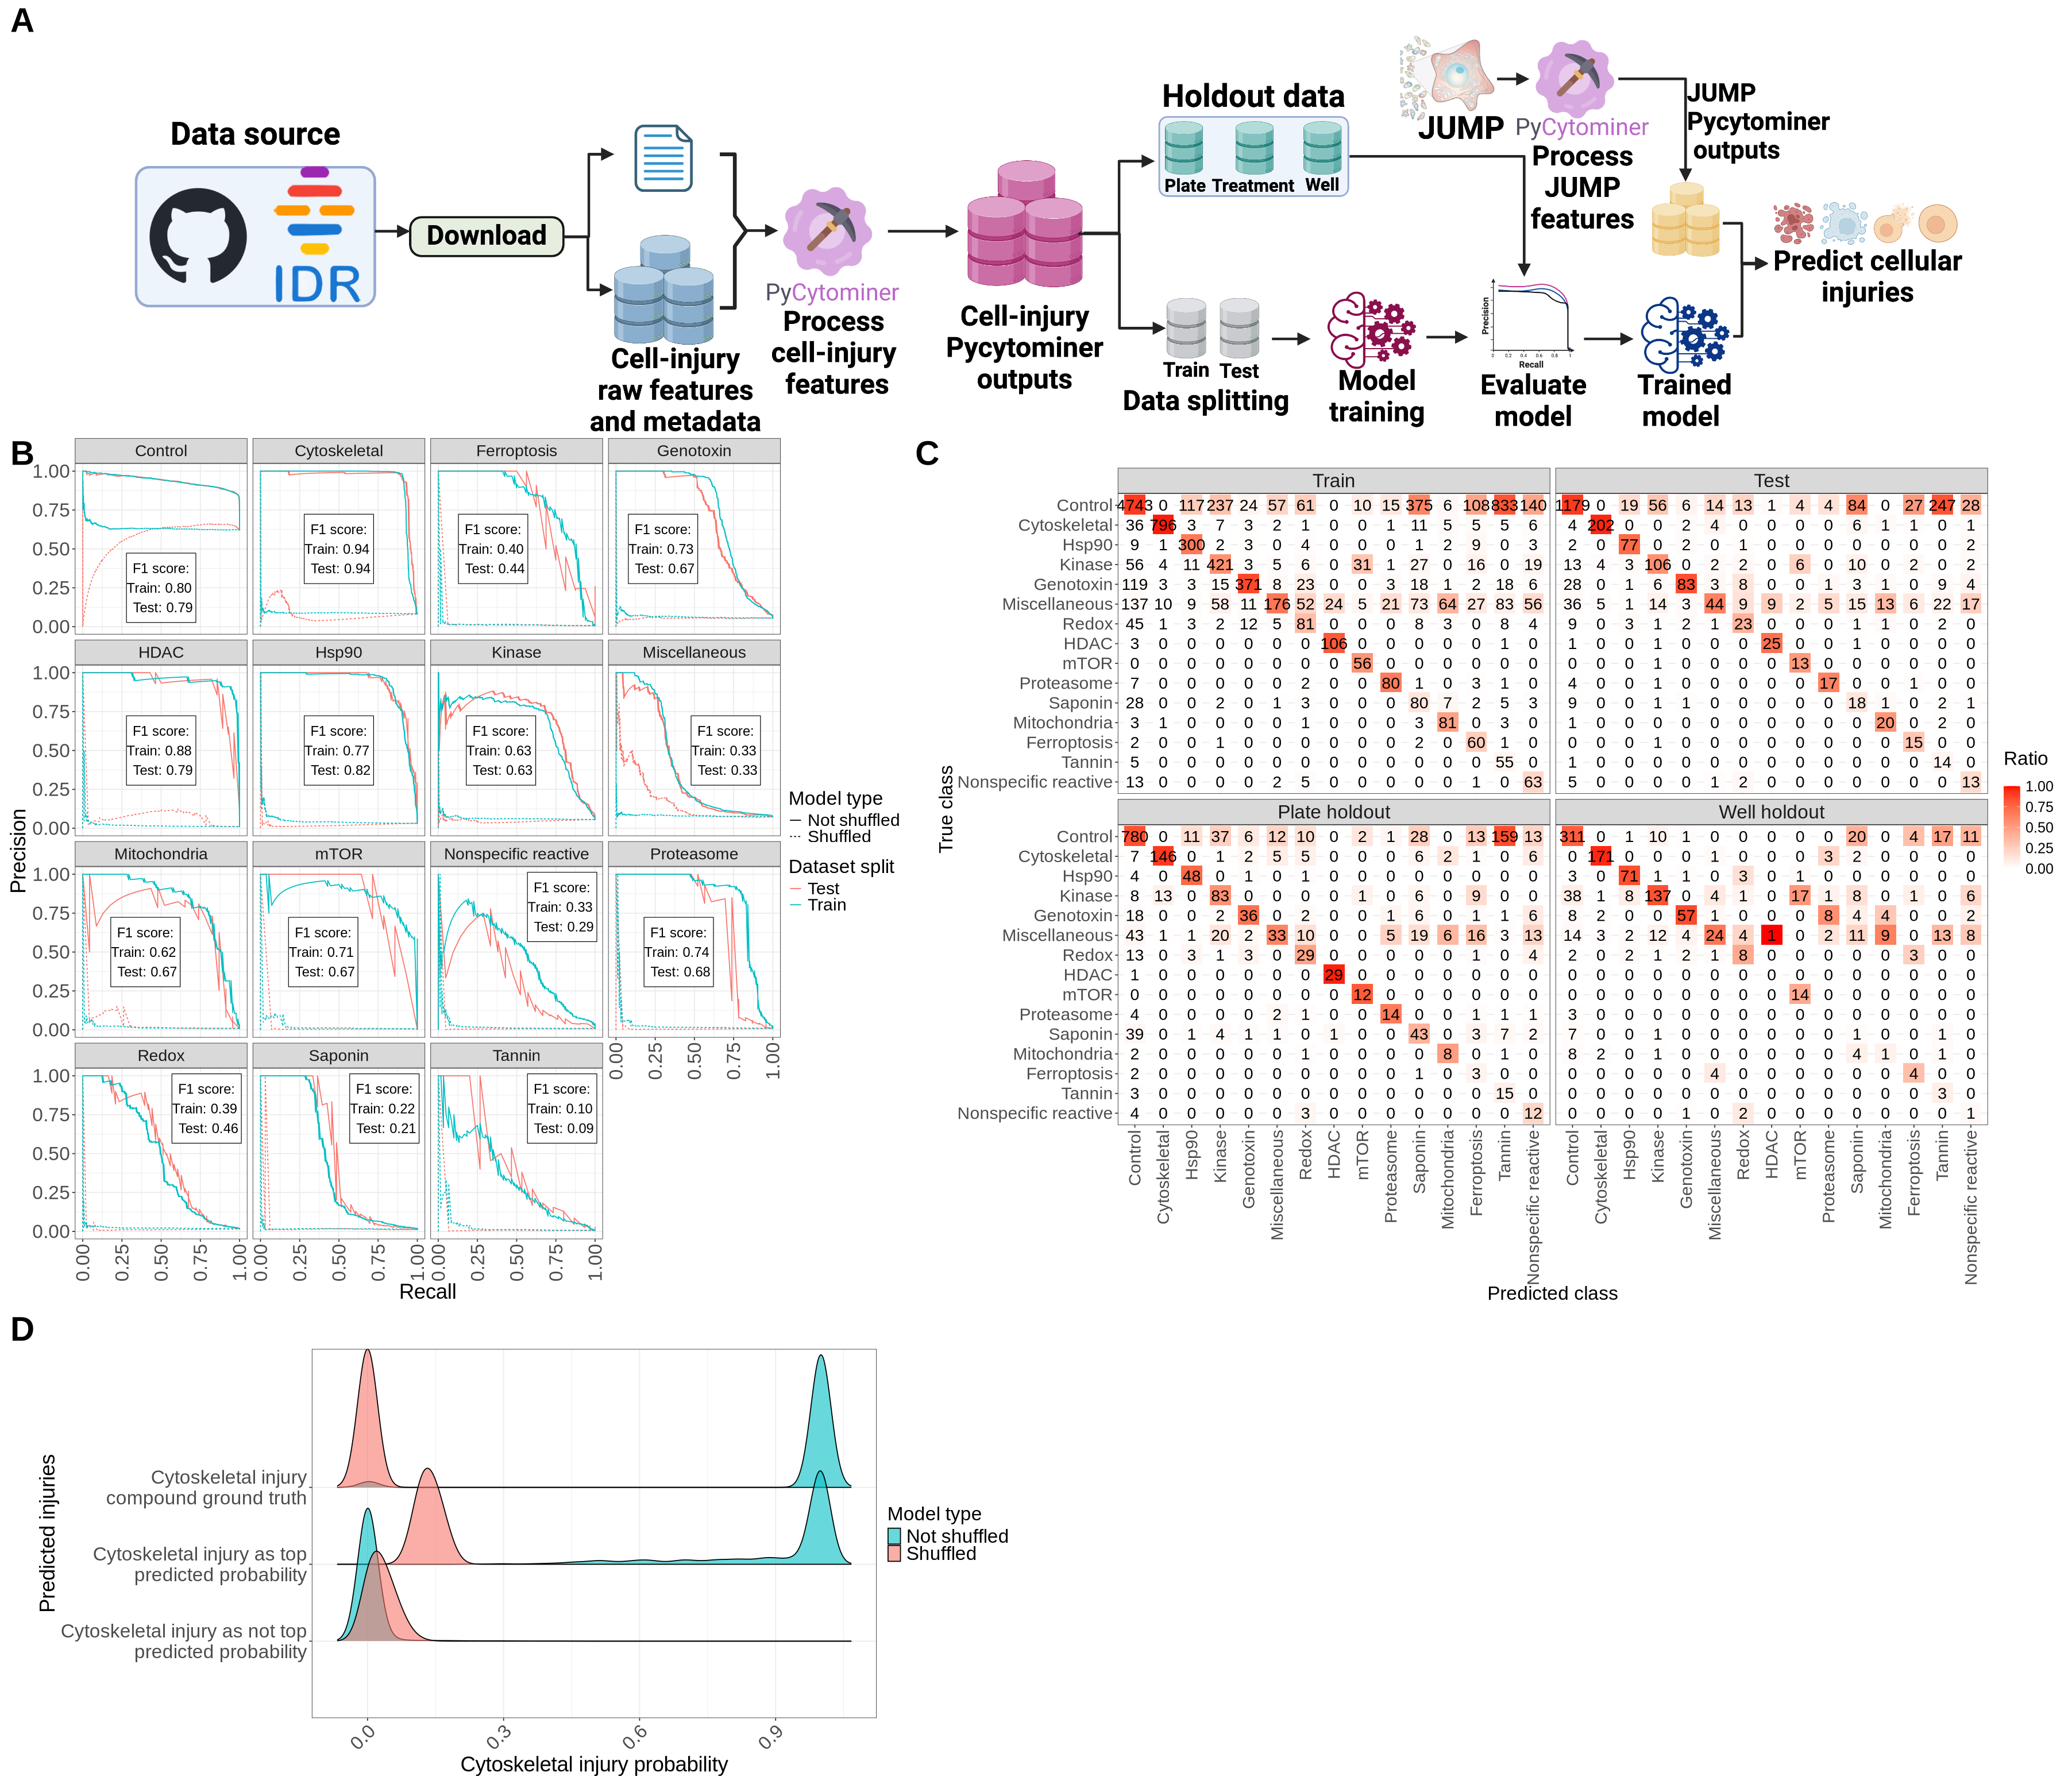

In [18]:
# Define plot dimensions
# height = 25
# width = 28

height <- 26
width <- 30

layout <- c(
    area(t=0, b=1, l=0, r=25), # A
    area(t=2, b=4, l=0, r=11), # B
    area(t=2, b=4, l=12, r=25), # C
    area(t=5, b=6, l=0, r=12), # D
    area(t=5, b=6, l=13, r=25) # empty space
)
options(repr.plot.width=width, repr.plot.height=height, units = "in", dpi = 900)

fig2 <- (
    free(fig2_A_wf_image)
    + wrap_elements( full = fig2_B_pr_curve_plot_train_test)
    + free(fig2_C_final_model_cm)
    + wrap_elements(fig2_D_probabilities_ridge_plot)
    + plot_spacer()

    # plot layouts
    + plot_layout(design = layout, heights = c(1, 1, 0.1))
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 35, face = "bold"))
)

# Display the combined plot
fig2

# Save the plot
ggsave(
  plot = fig2,
  filename = "figures/Final_Figure2.png",
  height = height,
  width = width,
  dpi = 700
)